In [1]:
# !curl --remote-name-all https://repository.clarin.is/repository/xmlui/bitstream/handle/20.500.12537/236{/IGC-News1-22.10.TEI.zip}
# !curl --remote-name-all https://repository.clarin.is/repository/xmlui/bitstream/handle/20.500.12537/238{/IGC-News2-22.10.TEI.zip}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 30  595M   30  179M    0     0  35.5M      0  0:00:16  0:00:05  0:00:11 36.7M^C


In [ ]:
# !unzip ./IGC-Parla-22.10.TEI.zip

Archive:  ./IGC-Parla-22.10.TEI.zip
   creating: IGC-Parla-22.10.TEI/
   creating: IGC-Parla-22.10.TEI/1935/
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-15-uni-1.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-15.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-18.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-19.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-20.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-21.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-22.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-23.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-25.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-26.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-27.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-28.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-03-01.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IG

In [ ]:
!mv ./IGC-Parla-22.10.TEI ./data

In [ ]:
!mkdir ./processed_data

In [5]:
# read xml file
import os
import xml.etree.ElementTree as ET
import re

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

all_paths = []
for root, dirs, files in os.walk("./data/"):
    for file in files:

        if file.endswith(".xml"):
             all_paths.append(os.path.join(root, file))

all_paths

# don't include the readme file
all_paths = all_paths[1:]

def read_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    text = []
    for elem in root.iter():
        if elem.text is not None:
            text.append(elem.text.strip())

    extracted_text = " ".join(text)

    # extracted_text = extracted_text[1030:].strip()
    prescript_len = len(extracted_text.split('      ')[0])
    extracted_text = extracted_text[prescript_len:].strip()

    return extracted_text

def save(path, data):
    with open(path, 'w') as f:
        f.write(data)


def clean_dir(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            os.remove(os.path.join(root, file))

clean_dir('./processed_data')

max_count = len(all_paths)

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

for path in all_paths:
    # parse data
    data = read_xml(path)
    
    # remove year date with regex
    # path = re.sub(r'\d{4}/', '', path)


    # remove everything upto the last slash
    path = path.split('/')[-1]

    path = path.replace('.xml', '.txt')
    path = './processed_data/' + path
    
    # save data
    save(path, data)

    f.value += 1 # signal to increment the progress bar

IntProgress(value=0, max=1787739)

In [6]:
!pip install torchinfo
!pip install tokenizers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

from tqdm.auto import tqdm

from pathlib import Path

import matplotlib.pyplot as plt

from tokenizers import Tokenizer
from tokenizers.models import BPE
import tokenizers.pre_tokenizers as pre_tokenizers
import tokenizers.processors as processors
import tokenizers.decoders as decoders
from tokenizers.trainers import BpeTrainer

from torchinfo import summary

torch.manual_seed(1357)

In [8]:
data[:100], data[:100]

('Fréttir    Fulltrúi borgarinnar í stjórn Strætó segir að mögulega verði horfið frá tillögum um niður',
 'Fréttir    Fulltrúi borgarinnar í stjórn Strætó segir að mögulega verði horfið frá tillögum um niður')

# BPE Tokenizer

In [9]:
import os

all_paths = []
for root, dirs, files in os.walk("./processed_data"):
    for file in files:
        if file.endswith(".txt"):
             all_paths.append(os.path.join(root, file))

tokenizer_path = Path('./tokenizer/')
tokenizer_path.mkdir(exist_ok=True)

tokenizer = Tokenizer(BPE())

tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()
trainer = BpeTrainer(special_tokens=['<|endoftext|>'], min_frequency=2)

# tokenizer.train_from_iterator([data], trainer=trainer, length=len(data))
tokenizer.train(all_paths, trainer=trainer)

# tokenizer.train(['/kaggle/input/shakespeare-full-text/shakespeare.txt'],trainer)
tokenizer.save(str(tokenizer_path / 'parliament.json'))

In [3]:
tokenizer_path = Path('./tokenizer/')

tokenizer = Tokenizer.from_file(str(tokenizer_path / 'parliament.json'))

# Config

In [385]:
# larger model

@dataclass
class Config:
    
    block_size = 256 # context-length
    # batch_size = 64 # mini-batch size
    batch_size = 4 # mini-batch size
    file_batch_size = 4 # no. of files to load at once
    
    vocab_size = tokenizer.get_vocab_size()
    
    train_size = 0.9 
    
    n_embed = 384
    n_heads = 6
    head_size = n_embed // n_heads # computes to 384/6=64
    
    n_layers = 3
    
    # train_iters = 20
    # val_iters = 2
    train_iters = 5000 # no. of batches to train on
    val_iters = 1000 # no. of batches to validate on every eval_intervals
    
    eval_interval = int(train_iters/10) # validate after every eval_interval iterations while training
    
    lr = 5e-4
    
    attn_dropout = 0.2
    block_dropout = 0.2
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
Config.device, Config.vocab_size

('cuda', 30000)

# Dataset

In [404]:
import os
from tqdm.notebook import tqdm

class ParliamentDataset:
    def __init__(self, Config, is_test=False) -> None:
        all_paths = []
        for root, dirs, files in os.walk("processed_data"):
            for file in files:
                if file.endswith(".txt"):
                    all_paths.append(os.path.join(root, file))

        self.data = []
        all_paths = all_paths[:int(len(all_paths) * 0.11)]

        self.tokenizer = Tokenizer.from_file('./tokenizer/parliament.json')

        progress_bar = tqdm(total=len(all_paths), desc="Loading data", unit="files")

        file_batch = []
        for idx, file_path in enumerate(all_paths):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
                    if len(text) > Config.block_size:
                        encoded = self.tokenizer.encode(text).ids
                        tensor = torch.tensor(encoded, dtype=torch.long)
                        file_batch.append(tensor)

                        del encoded
                        del tensor
                    else:
                        pass
            except Exception as e:
                print(e)
                print(file_path)
                continue

            if len(file_batch) >= Config.file_batch_size:
                self.data.append(torch.cat(file_batch))
                file_batch = []

            progress_bar.update(1)  # Update the progress bar

        progress_bar.close()  # Close the progress bar

        if file_batch:
            self.data.append(torch.cat(file_batch))

        self.data = torch.cat(self.data)  # Join the tensors into a single tensor

        self.is_test = is_test
        if self.is_test:
            self.data = self.data[int(Config.train_size * len(self.data)):]
        else:
            self.data = self.data[:int(Config.train_size * len(self.data))]

        self.block_size = Config.block_size
        self.batch_size = Config.batch_size

    def __len__(self) -> int:
        return len(self.data)

    def get_block_size(self) -> int:
        return self.block_size

    def get_vocab_size(self) -> int:
        return self.tokenizer.get_vocab_size()

    def __next__(self):
        ix = torch.randint(len(self.data) - self.block_size, (self.batch_size,))
        x = torch.stack([self.data[i:i+self.block_size] for i in ix])
        y = torch.stack([self.data[i+1:i+self.block_size+1] for i in ix])
        return x, y


In [405]:
# print("Train Dataset")
# train_dataset = ParliamentDataset(Config)

In [406]:
# train_dataset.__next__()[0].shape, train_dataset.__next__()[1].shape
# tokenizer.decode(train_dataset.__next__()[0][0].tolist()), tokenizer.decode(train_dataset.__next__()[1][0].tolist())
# train_dataset.data[1].tolist()
# 
# iter(train_dataset).__next__()[0].shape, iter(train_dataset).__next__()[1].shape]]

# train_dataset.all_paths

---

# **GPT Model**

## Single Attention Head

In [407]:
class AttentionHead(nn.Module):
    def __init__(self, Config):
        super().__init__()

        self.block_size = Config.block_size
        self.n_embed = Config.n_embed
        self.head_size = Config.head_size
        
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False)
        
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False)

        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.block_size,self.block_size))
        )
        
        self.dropout = nn.Dropout(Config.attn_dropout)

    def forward(self, x):

        B,T,C = x.shape

        k = self.key(x)
        q = self.query(x)

        wei = q@k.transpose(-2,-1) * (C ** 0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        v = self.value(x)
        out = wei @ v
        
        return out

## MultiHead Attention

In [408]:
class MultiHeadAttention(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.n_heads = Config.n_heads
        self.head_size = Config.head_size
        
        self.heads = nn.ModuleList([AttentionHead(Config) for _ in range(self.n_heads)])
        
        self.projection = nn.Linear(Config.n_embed, Config.n_embed)
        
        self.dropout = nn.Dropout(Config.attn_dropout)
    
    def forward(self,x):
        x = torch.cat([h(x) for h in self.heads],dim=-1)
        x = self.projection(x)
        x = self.dropout(x)
        return x

## Feed Forward Layer

# Transformer Block

In [409]:
class TransformerBlock(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.attn = MultiHeadAttention(Config)
        self.ff = FeedForward(Config)
        self.ln1 = nn.LayerNorm(Config.n_embed)
        self.ln2 = nn.LayerNorm(Config.n_embed)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        
        return x

## GPT Model

In [410]:
class ISLParliamentGPT(nn.Module):
    def __init__(self,Config):
        super().__init__()
        
        self.n_embed = Config.n_embed
        self.block_size = Config.block_size
        
        self.token_embedding_table = nn.Embedding(Config.vocab_size,self.n_embed)
        self.pos_embedding_table = nn.Embedding(self.block_size, self.n_embed)
        
        self.blocks = nn.Sequential(
            *[TransformerBlock(Config)]*Config.n_layers,
            nn.LayerNorm(self.n_embed)
        )

        self.lm_head = nn.Linear(self.n_embed,Config.vocab_size)
        
    def forward(self,idx):
        
        B,T = idx.shape
        
        token_embs = self.token_embedding_table(idx)
        pos_embs = self.pos_embedding_table(torch.arange(T,device=Config.device))
        
        
        x = token_embs + pos_embs
        x = self.blocks(x)
        logits = self.lm_head(x)
        
        return logits

        
    def generate(self,idx,total):
        for _ in range(total):
            idx_cond = idx[:, -self.block_size:]
            logits= self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
            

In [411]:
class FeedForward(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(Config.n_embed,Config.n_embed * 4),
            nn.ReLU(),
            nn.Linear(Config.n_embed * 4, Config.n_embed), # projection
            nn.Dropout(Config.block_dropout)
        )
    def forward(self,x):
        return self.net(x)

# Training

In [412]:
# print("Train Dataset")
train_ds = ParliamentDataset(Config)
# print("Val Dataset")
val_ds = ParliamentDataset(Config,is_test=True)

Loading data:   0%|          | 0/196651 [00:00<?, ?files/s]

Loading data:   0%|          | 0/196651 [00:00<?, ?files/s]

KeyboardInterrupt: 

In [ ]:
lm = ISLParliamentGPT(Config)
lm = lm.to(device=Config.device)

In [ ]:
summary(lm,input_size=(Config.batch_size, Config.block_size),dtypes=[torch.long],depth=5,)

Layer (type:depth-idx)                        Output Shape              Param #
ISLParliamentGPT                              [4, 256, 30000]           --
├─Embedding: 1-1                              [4, 256, 384]             11,520,000
├─Embedding: 1-2                              [256, 384]                98,304
├─Sequential: 1-3                             [4, 256, 384]             --
│    └─TransformerBlock: 2-1                  [4, 256, 384]             --
│    │    └─LayerNorm: 3-1                    [4, 256, 384]             768
│    │    └─MultiHeadAttention: 3-2           [4, 256, 384]             --
│    │    │    └─ModuleList: 4-9              --                        (recursive)
│    │    │    │    └─AttentionHead: 5-1      [4, 256, 64]              73,728
│    │    │    │    └─AttentionHead: 5-2      [4, 256, 64]              73,728
│    │    │    │    └─AttentionHead: 5-3      [4, 256, 64]              73,728
│    │    │    │    └─AttentionHead: 5-4      [4, 256, 64]   

### Optimizer

In [ ]:
optim = torch.optim.AdamW(lm.parameters(), lr=Config.lr)

### Loss Function

In [ ]:
def loss_fn(logits, targets):
    B,T,C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits,targets)
    return loss

# Training Loops

## Validation Loop

averages over `val_iters` mini-batches

In [ ]:
@torch.no_grad()
def valid_N_iters():
    val_step_losses = []
    for batch in tqdm(range(Config.val_iters)):
        inputs, targets = next(val_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        val_step_losses.append(loss.item())
        
        del inputs, targets, loss, logits
    
    val_loss = torch.tensor(val_step_losses).mean()
    print(f'val loss: {val_loss}')
    return val_loss

## Training Loop

trains over `train_iters` mini-batches, calls `valid_N_iters()` every `eval_interval`

In [ ]:
def train_N_iters():
    lm.train()
    train_step_losses = []
    val_losses = []
    for batch in tqdm(range(Config.train_iters)):
        optim.zero_grad()
        inputs, targets = next(train_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        loss.backward()
        optim.step()
        train_step_losses.append(loss.item())
        
        if batch%(Config.train_iters//10)==0 or batch==Config.train_iters-1:
            print(f"\n{'-'*50}\nbatch {batch} train step loss: {loss.item()}")
            print(f"train loss so far: {torch.tensor(train_step_losses).mean()}\n{'-'*50}\n")
            
        if batch%Config.eval_interval==0 or batch==Config.train_iters-1:
            lm.eval()
            val_loss = valid_N_iters()
            lm.train()
            val_losses.append(val_loss.item())
            
            del val_loss
            
        del inputs, targets, loss, logits
        
    return train_step_losses, val_losses

In [ ]:
def save_lm():
    state_dict = lm.state_dict()
    save_path = Path('./').resolve() / 'isl_parliament_gpt'
    save_path.mkdir(exist_ok=True)
    model_path = save_path / f'isl_parliament_gpt.pth'
    torch.save(state_dict, model_path)

In [ ]:
def train_lm():
    train_step_losses,val_losses = train_N_iters() 
    save_lm()
    return train_step_losses,val_losses

In [ ]:
tsl,vl=train_lm()

  0%|          | 0/5000 [00:00<?, ?it/s]


--------------------------------------------------
batch 0 train step loss: 10.447360038757324
train loss so far: 10.447360038757324
--------------------------------------------------



  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Loss Plots

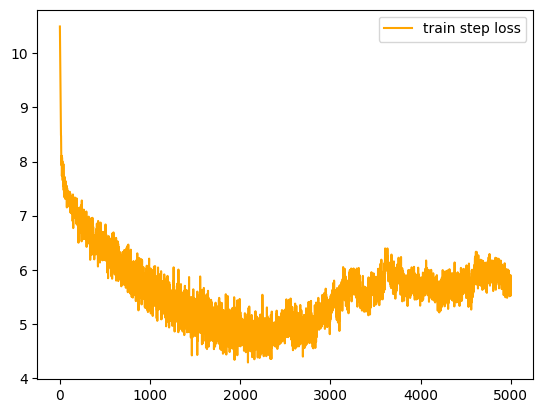

In [ ]:
plt.plot(tsl,label='train step loss',color='orange')
plt.legend()
plt.show()

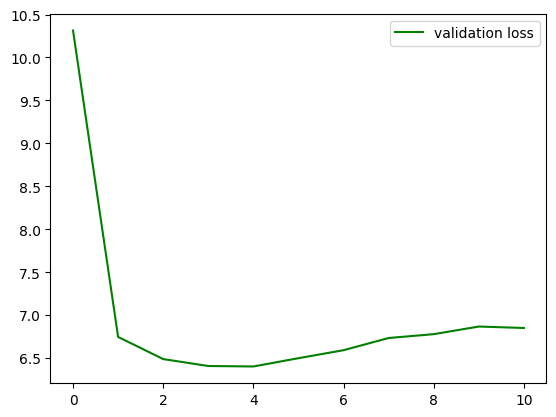

In [ ]:
plt.plot(vl,label='validation loss',color='green')
plt.legend()
plt.show()

In [ ]:
# tsl_mean = torch.tensor(tsl).mean()
# print('Train Loss:',tsl_mean.item())

# Generating

In [ ]:
generated_texts = []
for length in [100,300,500,700,1000]:
    generated = lm.generate(
    torch.zeros((1,1),dtype=torch.long,device=Config.device)+14, # initial context 161 (i believe its " ")
    total=length
)
    generated = tokenizer.decode(generated[0].cpu().numpy())
    text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
    generated_texts.append(text)
    print(text)

generated (100 tokens)
.Fréttir    Evrópusambandsinss fyrir að endurfjármuna.Fréttir    Ísraelaurum bandarísk þr breið var handtekinn 1990tilraunir þó hún sé ákveðin í Lettlandials hálfan.Fréttir    Fjölbrauta vilja forsetinn aðeinsul á bankareikon þangaðAustur hátíðarum. Rúmlegajú með nöfnum við sér gáfulu sig undirafélaginu fyrir tvær þriggja sínum frumsýnd. Hún lögreglu hefur rce slóðum kviknaðibol. Þetta og íbúarnir í. vikasíða og stökk innistæður Harald nyr ka hefur sagtjum þar. Þetta hann tók Mohamed upp Norður-0dd og en fyrir


generated (300 tokens)
.Fréttir    Vísind hefureyjum sem eiga starfsemi sambandsins páfa viðbrögð verið meira hægt á svæði að fleiri sérfræðingavopnum.a. janúar með þekkta ári hann.Fréttir    Maður liðsins sem grunaðurinu með. T í Aþenuvarökumefna um sigur:00 í eigu Ian að Hver varð að beita sem 6 lýsti því á næstu dögum var skorað og mikil að hleypa út myndi sé skotiðat rétt kunnugt Sif í Peking. Fundurinn.Fréttir    Loftslag Shar al völdin um innflytjen

In [ ]:
with open('generated.txt','w') as f:
    for text in generated_texts:
        f.write(text)

In [ ]:
input_text = "Frettir    "
input = tokenizer.encode(input_text, add_special_tokens=False)
input_ids = torch.tensor(input.ids, dtype=torch.long, device=Config.device).unsqueeze(0)

input.tokens, input.ids, input_ids

(['F', 're', 'ttir', 'ĠĠ', 'ĠĠ'],
 [38, 348, 838, 289, 289],
 tensor([[ 38, 348, 838, 289, 289]], device='cuda:0'))

In [ ]:


length = 50
generated = lm.generate(
    input_ids,
    total=length
)

generated = tokenizer.decode(generated[0].cpu().numpy())
text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
print(text)

generated (50 tokens)
Frettir     var til hústumlum aðgerðum Jens Stoltenberg kostiamennögu þungt á stjórnartíð verða um 300 varnarmálaráðherra, varnarmálaráð einum. 13umnu. Þeir og hefur til áein olí Kos 1997 og á morgun unglinga borgarstjóra    Kona Sjónvarpsinsfa við Hvíta nöfnumstjórn í


